In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import numpy as np
from retinaface.pre_trained_models import get_model
from retinaface.utils import vis_annotations

In [2]:
torch.cuda.is_available()

True

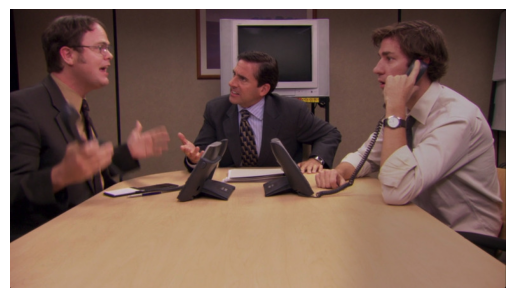

In [3]:
# load an input image

image_url = 'https://www.looper.com/img/gallery/the-office-funniest-moments-ranked/jim-and-dwights-customer-service-training-1627594561.jpg'
# image_url = "https://ew.com/thmb/n5b8Asz4Y5Lp0sSEF7WgS-ESyFc=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/succession-finale-052923-ec304aabcbf24a7b9fad891a87f49b74.jpg"
# image_url = "https://i.kym-cdn.com/entries/icons/original/000/045/575/blackcatzoningout_meme.jpg"

try:
    response = requests.get(image_url, stream=True)
    response.raise_for_status()

    image = Image.open(BytesIO(response.content))
    width, height = image.size

    plt.imshow(image)
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f'Error downloading image: {e}')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load Gaze-LLE model
model, transform = torch.hub.load('fkryan/gazelle', 'gazelle_dinov2_vitl14_inout')
model.eval()
_ = model.to(device)

Using cache found in C:\Users\napochaan/.cache\torch\hub\fkryan_gazelle_main
Using cache found in C:\Users\napochaan/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\napochaan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
C:\Users\napochaan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
C:\Users\napochaan/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [5]:
model1 = get_model('resnet50_2020-07-20', max_size=2048)
model1.eval()

results = model1.predict_jsons(np.array(image))
bboxes = [result['bbox'] for result in results]
bboxes

C:\Users\napochaan\Desktop\gazelle\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\napochaan\Desktop\gazelle\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\napochaan\Desktop\gazelle\.venv\Lib\site-packages\torch\hub.py:768: FutureWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  return _legacy_zip_load(cached_file, model_dir, map_location, weights_only)


[[343, 78, 392, 148], [573, 38, 636, 145], [102, 24, 159, 120]]

In [6]:
# prepare gazelle input
img_tensor = transform(image).unsqueeze(0).to(device)
norm_bboxes = [
    [np.array(bbox) / np.array([width, height, width, height]) for bbox in bboxes]
]

input = {
    'images': img_tensor,  # [num_images, 3, 448, 448]
    'bboxes': norm_bboxes,  # [[img1_bbox1, img1_bbox2...], [img2_bbox1, img2_bbox2]...]
}

with torch.no_grad():
    output = model(input)

img1_person1_heatmap = output['heatmap'][0][0]  # [64, 64] heatmap
print(img1_person1_heatmap.shape)
if model.inout:
    img1_person1_inout = output['inout'][0][
        0
    ]  # gaze in frame score (if model supports inout prediction)
    print(img1_person1_inout.item())

torch.Size([64, 64])
0.9942483901977539


C:\Users\napochaan\Desktop\gazelle\.venv\Lib\site-packages\timm\models\vision_transformer.py:93: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  x = F.scaled_dot_product_attention(


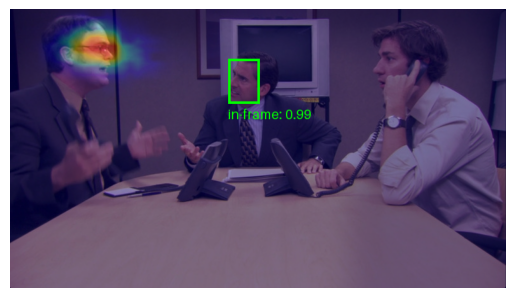

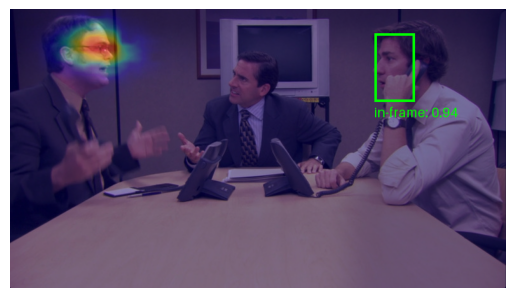

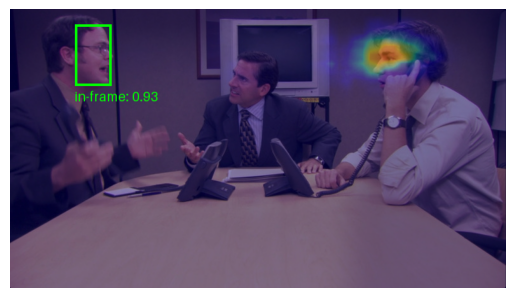

In [7]:
# visualize predicted gaze heatmap for each person and gaze in/out of frame score


def visualize_heatmap(pil_image, heatmap, bbox=None, inout_score=None):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    heatmap = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
        pil_image.size, Image.Resampling.BILINEAR
    )
    heatmap = plt.cm.jet(np.array(heatmap) / 255.0)
    heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
    heatmap = Image.fromarray(heatmap).convert('RGBA')
    heatmap.putalpha(90)
    overlay_image = Image.alpha_composite(pil_image.convert('RGBA'), heatmap)

    if bbox is not None:
        width, height = pil_image.size
        xmin, ymin, xmax, ymax = bbox
        draw = ImageDraw.Draw(overlay_image)
        draw.rectangle(
            [xmin * width, ymin * height, xmax * width, ymax * height],
            outline='lime',
            width=int(min(width, height) * 0.01),
        )

        if inout_score is not None:
            text = f'in-frame: {inout_score:.2f}'
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text(
                (text_x, text_y),
                text,
                fill='lime',
                font=ImageFont.load_default(size=int(min(width, height) * 0.05)),
            )
    return overlay_image


for i in range(len(bboxes)):
    plt.figure()
    plt.imshow(
        visualize_heatmap(
            image,
            output['heatmap'][0][i],
            norm_bboxes[0][i],
            inout_score=output['inout'][0][i] if output['inout'] is not None else None,
        )
    )
    plt.axis('off')
    plt.show()

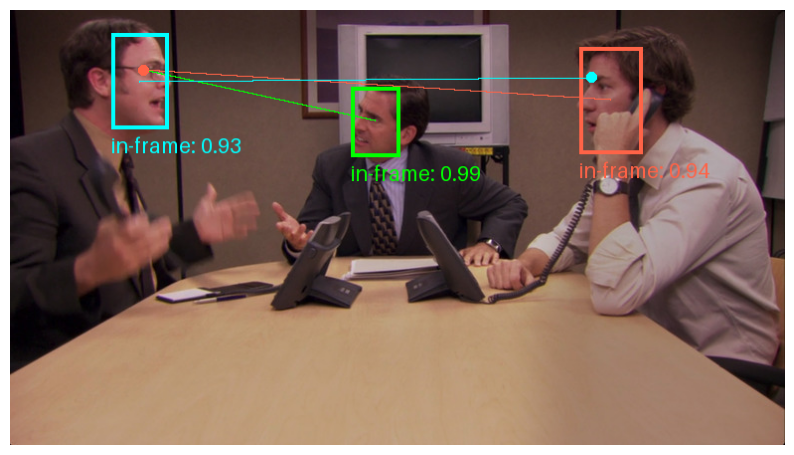

In [8]:
# combined visualization with maximal gaze points for each person


def visualize_all(pil_image, heatmaps, bboxes, inout_scores, inout_thresh=0.5):
    colors = ['lime', 'tomato', 'cyan', 'fuchsia', 'yellow']
    overlay_image = pil_image.convert('RGBA')
    draw = ImageDraw.Draw(overlay_image)
    width, height = pil_image.size

    for i in range(len(bboxes)):
        bbox = bboxes[i]
        xmin, ymin, xmax, ymax = bbox
        color = colors[i % len(colors)]
        draw.rectangle(
            [xmin * width, ymin * height, xmax * width, ymax * height],
            outline=color,
            width=int(min(width, height) * 0.01),
        )

        if inout_scores is not None:
            inout_score = inout_scores[i]
            text = f'in-frame: {inout_score:.2f}'
            text_width = draw.textlength(text)
            text_height = int(height * 0.01)
            text_x = xmin * width
            text_y = ymax * height + text_height
            draw.text(
                (text_x, text_y),
                text,
                fill=color,
                font=ImageFont.load_default(size=int(min(width, height) * 0.05)),
            )

        if inout_scores is not None and inout_score > inout_thresh:
            heatmap = heatmaps[i]
            heatmap_np = heatmap.detach().cpu().numpy()
            max_index = np.unravel_index(np.argmax(heatmap_np), heatmap_np.shape)
            gaze_target_x = max_index[1] / heatmap_np.shape[1] * width
            gaze_target_y = max_index[0] / heatmap_np.shape[0] * height
            bbox_center_x = ((xmin + xmax) / 2) * width
            bbox_center_y = ((ymin + ymax) / 2) * height

            draw.ellipse(
                [
                    (gaze_target_x - 5, gaze_target_y - 5),
                    (gaze_target_x + 5, gaze_target_y + 5),
                ],
                fill=color,
                width=int(0.005 * min(width, height)),
            )
            draw.line(
                [(bbox_center_x, bbox_center_y), (gaze_target_x, gaze_target_y)],
                fill=color,
                width=int(0.005 * min(width, height)),
            )

    return overlay_image


plt.figure(figsize=(10, 10))
plt.imshow(
    visualize_all(
        image,
        output['heatmap'][0],
        norm_bboxes[0],
        output['inout'][0] if output['inout'] is not None else None,
        inout_thresh=0.5,
    )
)
plt.axis('off')
plt.show()